In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

from datasets import load_dataset
emotions = load_dataset("emotion")

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/home/jerdavies/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

# From Text to Tokens
Transformer models like DistilBERT cannot receive raw strings as input; instead, they assume the text has been tokenized and encoded as numerical vectors. Tokenization is the step of breaking down a string into the atomic units used in the model. There are several tokenization strategies one can adopt, and the optimal splitting of words into subunits is usually learned from the corpus. Before looking at the tokenizer used for DistilBERT, let’s consider two extreme cases: character and word tokenization.

In [2]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


This is a good start, but we’re not done yet. Our model expects each character to be converted to an integer, a process sometimes called numericalization. One simple way to do this is by encoding each unique token (which are characters in this case) with a unique integer:

In [3]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


This gives us a mapping from each character in our vocabulary to a unique integer. We can now use token2idx to transform the tokenized text to a list of integers:

In [4]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


Each token has now been mapped to a unique numerical identifier (hence the name input_ids). The last step is to convert input_ids to a 2D tensor of one-hot vectors. One-hot vectors are frequently used in machine learning to encode categorical data, which can be either ordinal or nominal. 

For example, suppose we wanted to encode the names of characters in the Transformers TV series. One way to do this would be to map each name to a unique ID, as follows:

In [5]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


The problem with this approach is that it creates a **fictitious ordering** between the names, and neural networks are really good at learning these kinds of relationships. So instead, we can create a new column for each category and assign a 1 where the category is true, and a 0 otherwise. In Pandas, this can be implemented with the get_dummies() function as follows:

In [6]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


The rows are now single **hot** vectors with 1 and 0 everywhere else. 

In [7]:
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings

tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0,

By examining the first vector, we can verify that a 1 appears in the location indicated by input_ids[0]:

In [8]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


From our simple example we can see that character-level tokenization ignores any structure in the text and treats the whole string as a stream of characters. Although this helps deal with misspellings and rare words, the main drawback is that linguistic structures such as words need to be learned from the data. This requires significant compute, memory, and data. For this reason, character tokenization is rarely used in practice. Instead, some structure of the text is preserved during the tokenization step. Word tokenization is a straightforward approach to achieve this, so let’s take a look at how it works.

## Word Tokenization
Instead of splitting the text into characters, we can split it into words and map each word to an integer. Using words from the outset enables the model to skip the step of learning words from characters, and thereby reduces the complexity of the training process.

One simple class of word tokenizers uses whitespace to tokenize the text. We can do this by applying Python’s split() function directly on the raw text (just like we did to measure the tweet lengths):

In [9]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


From here we can take the same steps we took for the character tokenizer to map each word to an ID. However, we can already see one potential problem with this tokenization scheme: punctuation is not accounted for, so NLP. is treated as a single token. Given that words can include declinations, conjugations, or misspellings, the **size of the vocabulary can easily grow into the millions!**

Having a **large vocabulary** is a **problem** because it requires neural networks to have an enormous number of parameters. To illustrate this, suppose we have **1 million unique words** and want to compress the **1-million-dimensional** input vectors to **1-thousand-dimensional vectors** in the **first layer of our neural network**. This is a standard step in most NLP architectures, and the resulting **weight matrix of this first layer would contain 1 million × 1 thousand = 1 billion weights**. This is already **comparable to the largest GPT-2 model,4 which has around 1.5 billion parameters** in total!

Naturally, we want to avoid being so wasteful with our model parameters since models are expensive to train, and larger models are more difficult to maintain. A **common approach is to limit the vocabulary and discard rare words** by considering, say, the **100,000 most common words** in the corpus. Words that are not part of the vocabulary are classified as “unknown” and mapped to a shared UNK token. This means that we lose some potentially important information in the process of word tokenization, since the model has no information about words associated with UNK.

## Subword Tokenization
The basic idea behind **subword tokenization** is to **combine** the best aspects of **character and word tokenization**. On the one hand, we want to **split rare words into smaller units** to allow the model to deal with complex words and misspellings. On the other hand, we want to **keep frequent words as unique entities** so that we can keep the length of our inputs to a manageable size. The main distinguishing feature of subword tokenization (as well as word tokenization) is that it is learned from the pretraining corpus using a mix of statistical rules and algorithms.

There are several subword tokenization algorithms that are commonly used in NLP, but let’s start with **WordPiece**, which is **used by the BERT and DistilBERT tokenizers**. The easiest way to understand how WordPiece works is to see it in action. 

Transformers provides a convenient **AutoTokenizer** class that allows you to **quickly load the tokenizer associated with a pretrained model**,  we just call its **from_pretrained()** method, providing the ID of a model on the Hub or a local file path. Let’s start by loading the tokenizer for DistilBERT:

In [10]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

The **AutoTokenizer** class belongs to a larger set of **“auto” classes** whose job is to **automatically retrieve the model’s configuration, pretrained weights, or vocabulary from the name of the checkpoint**. This allows you to quickly switch between models, but **if you wish to load the specific class manually** you can do so as well. For example, we could have loaded the DistilBERT tokenizer as follows:

In [11]:
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)
distilbert_tokenizer

DistilBertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [12]:
# Let’s examine how this tokenizer works by feeding it our simple “Tokenizing text is a core task of NLP.” example text:

encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Just **as with character tokenization**, we can see that the **words have been mapped to unique integers** in the input_ids field. We’ll **discuss the role of the attention_mask** field in the next section. Now that we have the input_ids, we can convert them back into tokens by using the tokenizer’s convert_ids_to_tokens() method:

We can observe three things here. First, some **special [CLS] and [SEP] tokens** have been added to the start and end of the sequence. These tokens differ from model to model, but their main role is to indicate the **start and end of a sequence**. Second, the tokens have each been **lowercased**, which is a **feature of this particular checkpoint**. Finally, we can see that “tokenizing” and “NLP” have been **split into two tokens**, which makes sense since they are **not common words**. The **## prefix** in ##izing and ##p means that the **preceding string is not whitespace**; any token with this prefix should be **merged with the previous token** when you convert the tokens back to a string. The AutoTokenizer class has a convert_tokens_to_string() method for doing just that, so let’s apply it to our tokens:

In [13]:
print(tokenizer.convert_ids_to_tokens(encoded_text.input_ids))

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [14]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

## Tokenizing the Whole Dataset
To tokenize the whole corpus, we’ll use the **map() method** of our **DatasetDict object**. We’ll encounter this method many times throughout this book, as it provides a **convenient way to apply a processing function to each element in a dataset**. As we’ll soon see, the map() method can also be used to create new rows and columns.

To get started, the first thing we need is a processing function to tokenize our examples with:

In [15]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

This function applies the tokenizer to a batch of examples; padding=True will pad the examples with zeros to the size of the longest one in a batch, and truncation=True will truncate the examples to the model’s maximum context size. To see tokenize() in action, let’s **pass a batch of two examples** from the training set:

In [16]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


By default, the map() method operates individually on every example in the corpus, so setting batched=True will encode the tweets in batches. Because we’ve set batch_size=None, our tokenize() function will be applied on the full dataset as a single batch. This ensures that the input tensors and attention masks have the same shape globally, and we can see that this operation has **added new input_ids and attention_mask columns** to the dataset:

In [17]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
print(emotions_encoded["train"].column_names)

Loading cached processed dataset at /home/jerdavies/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-4ad8cf602e7e0c67.arrow
Loading cached processed dataset at /home/jerdavies/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-bc8335e86e852ab2.arrow
Loading cached processed dataset at /home/jerdavies/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-a58e5c638054978e.arrow


['text', 'label', 'input_ids', 'attention_mask']


# Training a Text Classifier

We can’t use these language models directly for text classification; we need to modify them slightly. 

To understand what modifications are necessary, let’s take a look at the architecture of an encoder-based model like DistilBERT, which is depicted in Figure 2-4.

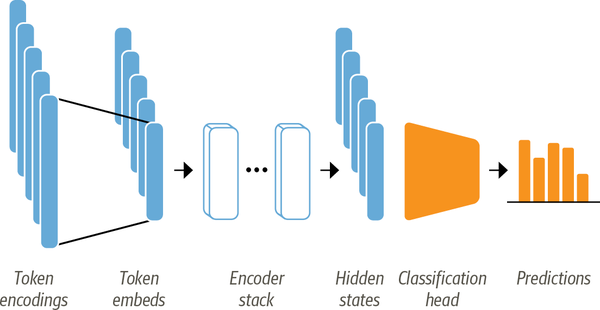

1. First, the text is **tokenized** and represented as **one-hot vectors** called token **encodings**. 

2. The size of the tokenizer vocabulary determines the dimension of the token encodings, and it usually consists of 20k–200k unique tokens. 

3. Next, these **token encodings** are converted to **token embeddings**, which are **vectors** living in a **lower-dimensional space**. 

4. The **token embeddings** are then passed through the **encoder block** layers to **yield a hidden state** for each **input token**. 

5. For the pretraining objective of language modeling,⁠ each **hidden state** is fed to a layer that predicts the **masked input tokens**. 

6. For the classification task, we **replace** the language modeling layer with a **classification layer**.

We have two options to train such a model on our Twitter dataset:

- Feature extraction

We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.

- Fine-tuning

We train the whole model end-to-end, which also updates the parameters of the pretrained model.

In the following sections we explore both options for DistilBERT and examine their trade-offs.

## Transformers as Feature Extractors
Using a transformer as a feature extractor is fairly simple. We freeze the body’s weights during training and use the hidden states as features for the classifier. The advantage of this approach is that we can quickly train a small or shallow model. Such a model could be a neural classification layer or a method that does not rely on gradients, such as a random forest. This method is especially convenient if GPUs are unavailable, since the hidden states only need to be precomputed once.

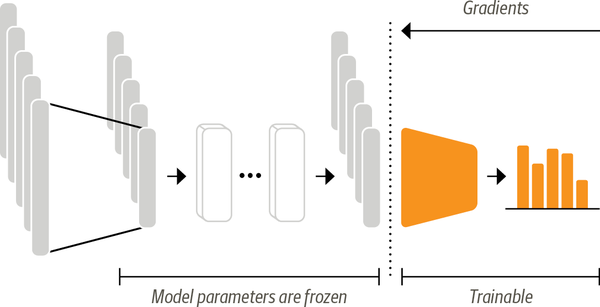!

## Using pretrained models
We will use another convenient auto class from Transformers called **AutoModel**. Similar to the **AutoTokenizer** class, **AutoModel** has a **from_pretrained()** method to load the weights of a pretrained model. 

Let’s use this method to load the DistilBERT checkpoint:

In [18]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Here we’ve used PyTorch to check whether a GPU is available or not, and then chained the **PyTorch nn.Module.to()** method to the model loader. 

This ensures that the model will run on the GPU if we have one. If not, the model will run on the CPU, which can be considerably slower.

The **AutoModel** class converts the **token encodings** to **embeddings**, and then feeds them **through the encoder stack to return the hidden states**. 

Let’s take a look at how we can extract these states from our corpus.

## Extracting the last hidden states
To warm up, let’s **retrieve the last hidden states for a single string**. 

The first thing we need to do is **encode** the string and **convert** the tokens **to PyTorch tensors**. This can be done by providing the **return_tensors="pt"** argument to the tokenizer as follows:

In [19]:
text = "this is a test"
inputs = tokenizer(text, return_tensors='pt')
print(f"Input tensor shape: {inputs['input_ids'].size()}")

tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

Input tensor shape: torch.Size([1, 6])


['[CLS]', 'this', 'is', 'a', 'test', '[SEP]']

Now that we have the **encodings as a tensor**, the final step is to **place them on the same device as the model** and **pass the inputs** as follows:

In [20]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
outputs

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)

Here we’ve used the **torch.no_grad()** context manager to disable the automatic calculation of the gradient. 

This is useful for inference since it reduces the memory footprint of the computations. Depending on the model configuration, the output can contain several objects, such as the hidden states, losses, or attentions, arranged in a class similar to a namedtuple in Python. In our example, the model output is an instance of BaseModelOutput, and we can simply access its attributes by name. 

The current model **returns only one attribute**, which is the **last hidden state**, so let’s examine its shape:

In [21]:
outputs.last_hidden_state.shape

torch.Size([1, 6, 768])

Looking at the hidden state tensor, we see that it has the shape 
- [batch_size, n_tokens, hidden_dim]. 

In other words, a **768-dimensional vector is returned** for **each of the 6 input tokens**. 

For classification tasks, it is **common practice** to just use the **hidden state associated with the [CLS] token** as the **input** feature. Since this token appears at the **start of each sequence**, we can **extract it by simply indexing into outputs.last_hidden_state** as follows:

In [22]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

Now we **know how to get the last hidden state for a single string**; let’s do the same for the **whole dataset** by **creating a new hidden_state column** that **stores all these vectors**. As we did with the tokenizer, we’ll use the **map()** method of DatasetDict to extract all the hidden states in one go. The first thing we need to do is wrap the previous steps in a processing function:

In [23]:
def extract_hidden_states(batch):
    # add to gpu
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    # extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # return vector for cls token
    return {'hidden_state': last_hidden_state[:,0].cpu().numpy()}

The only difference between this function and our previous logic is the **final step** where we place the **final hidden state back on the CPU as a NumPy array**. The map() method requires the processing function to return Python or NumPy objects when we’re using batched inputs.

In [24]:
# Since our model expects tensors as inputs, the next thing to do is convert the input_ids and
# attention_mask columns to the "torch" format, as follows:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [25]:
# We can then go ahead and extract the hidden states across all splits in one go:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Loading cached processed dataset at /home/jerdavies/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-f4ce1e6316bb0f98.arrow
Loading cached processed dataset at /home/jerdavies/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-bb1a88919b60f242.arrow
Loading cached processed dataset at /home/jerdavies/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-af71fa7e3dd9ee85.arrow


Notice that we did not set batch_size=None in this case, which means the default batch_size=1000 is used instead. As expected, applying the extract_​hid⁠den_​states() function has added a new hidden_state column to our dataset:

In [26]:
emotions_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

Now that we have the **hidden states** associated with each tweet, the next step is to **train a classifier** on them. To do that, we’ll need a **feature matrix**, let’s take a look.

### Creating a feature matrix
The preprocessed dataset now contains all the information we need to train a classifier on it. We will use the hidden states as input features and the labels as targets. We can easily create the corresponding arrays in the well-known Scikit-learn format as follows:

In [27]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))


Before we train a model on the hidden states, it’s good practice to perform a quick check to ensure that they provide a useful representation of the emotions we want to classify. In the next section, we’ll see how visualizing the features provides a fast way to achieve this.

### Visualizing the training set

Since visualizing the **hidden states in 768 dimensions** is **tricky** to say the least, we’ll use the powerful **UMAP algorithm** to **project** the vectors down to **2D**. Since **UMAP** works best when the features are scaled to lie in the [0,1] interval, we’ll first apply a **MinMaxScaler** and then use the UMAP implementation from the umap-learn library to reduce the hidden states:

In [28]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

2023-03-17 13:21:04.350960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 13:21:04.549990: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-17 13:21:04.586413: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-17 13:21:05.148647: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [29]:
# Scale features to [0,1]
X_scaled = MinMaxScaler().fit_transform(X_train)

# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])

df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.444113,6.253233,0
1,-2.843298,5.724005,0
2,5.306017,2.782934,3
3,-2.221837,3.280416,2
4,-3.096239,3.544295,3


The result is an array with the same number of training samples, but with only 2 features instead of the 768 we started with! Let’s investigate the compressed data a little bit further and plot the density of points for each category separately:

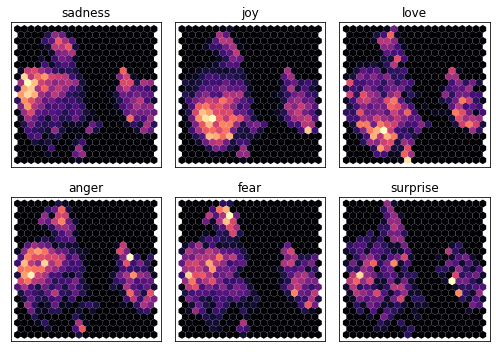

In [30]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()

cmaps = ["magma", "magma", "magma", "magma", "magma", "magma"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

From this plot we can see some clear patterns: the negative feelings such as sadness, anger, and fear all occupy similar regions with slightly varying distributions. On the other hand, joy and love are well separated from the negative emotions and also share a similar space. Finally, surprise is scattered all over the place. Although we may have hoped for some separation, this is in no way guaranteed since the model was not trained to know the difference between these emotions. It only learned them implicitly by guessing the masked words in texts.

Now that we’ve gained some insight into the features of our dataset, let’s finally train a model on it!

### Training a simple classifier

We’ve seen that the hidden states are somewhat different between the emotions, although for several of them there is no obvious boundary. Let’s use these hidden states to train a logistic regression model with Scikit-learn. Training such a simple model is fast and does not require a GPU:

In [31]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

Looking at the accuracy, it might appear that our model is just a bit better than random—but since we are dealing with an unbalanced multiclass dataset, it’s actually significantly better. We can examine whether our model is any good by comparing it against a simple baseline. In Scikit-learn there is a DummyClassifier that can be used to build a classifier with simple heuristics such as always choosing the majority class or always drawing a random class. In this case the best-performing heuristic is to always choose the most frequent class, which yields an accuracy of about 35%:

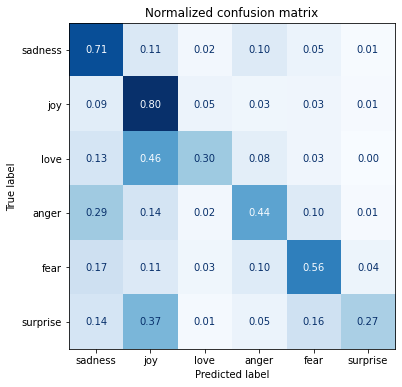

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

We can see that anger and fear are most often confused with sadness, which agrees with the observation we made when visualizing the embeddings. Also, love and surprise are frequently mistaken for joy.

In the next section we will explore the fine-tuning approach, which leads to superior classification performance. It is, however, important to note that doing this requires more computational resources, such as GPUs, that might not be available in your organization. In cases like these, a feature-based approach can be a good compromise between doing traditional machine learning and deep learning.

### Fine-Tuning Transformers

Let’s now explore what it takes to fine-tune a transformer end-to-end. With the fine-tuning approach we **do not use the hidden states as fixed features**, but instead **train them as shown**. This requires the **classification head to be differentiable**, which is why this method usually uses a neural network for classification.

![image.png](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098136789/files/assets/nlpt_0206.png)

Training the hidden states that serve as inputs to the classification model will help us avoid the problem of working with data that may not be well suited for the classification task. Instead, the **initial hidden states adapt** during training to **decrease the model loss** and thus **increase its performance**.

We’ll be using the Trainer API from **Transformers** to simplify the training loop. Let’s look at the ingredients we need to set one up!

### Loading a pretrained model

The first thing we need is a pretrained DistilBERT model like the one we used in the feature-based approach. The only slight modification is that we use the **AutoModelForSequenceClassification** model instead of **AutoModel**. The difference is that the **AutoModelForSequenceClassification** model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model. We just need to specify how many labels the model has to predict (six in our case), since this dictates the number of outputs the classification head has:

In [33]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

## Defining the performance metrics
To monitor metrics during training, we need to define a **compute_metrics()** function for the Trainer. This function receives an **EvalPrediction** object (which is a **named tuple** with predictions and label_ids attributes) and needs to return a dictionary that maps each metric’s name to its value. For our application, we’ll compute the **F1-score** and the **accuracy** of the model as follows:

In [34]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [35]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [36]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Your token h

In [37]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Cloning https://huggingface.co/yantofullpelt/distilbert-base-uncased-finetuned-emotion into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/home/jerdavies/.local/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.789600,0.295693,0.908500,0.905720
2,0.235000,0.209704,0.924500,0.924461


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
